In [34]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import Configuration
from RawDataset import RawDataset
from BirdsRecordingDataset import BirdsRecordingDataset
from Representation import LogMelSpectrogram
from Ensamble import Ensamble
from Trainer import Trainer
from ConvModel import CNNModel
from Augumentation import Adding_White_Noise, Amps_Augumentation, Hpps_Augumentation, Pitch_Shifting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
params = {
    "mels" : 80,
    "min_freq" : 4000,
    "max_freq" : 9500,
    "sr" : 44100
}

batch_size = 64
epoches = 50

models_path = "./models/"
train_path = "./train/"
test_path = "./test/"

class_weights = [1., 6.]

In [26]:
representation = LogMelSpectrogram(params)
rd = RawDataset(train_path, test_path, representation)
augumentation_methods = [Adding_White_Noise(), Amps_Augumentation()]


(3589, 44100)
(3589, 1, 80, 87)


In [27]:
X_train, y_train, X_valid, y_valid = rd.get_train_val_set()

In [5]:
print(len(X_valid))

718


In [30]:
X_test.shape

(924, 1, 80, 87)

In [6]:
brd_train = BirdsRecordingDataset(X_train, y_train, representation, augumentation_methods)
brd_valid = BirdsRecordingDataset(X_valid, y_valid, representation, [], train = False)


len(brd_train)
len(brd_valid)

718

In [7]:
train_loader = DataLoader(brd_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(brd_valid, batch_size = batch_size)

In [18]:
for x, y in test_loader:
    print(x.shape, y.shape)

torch.Size([1, 80, 87]) torch.Size([1])


In [8]:
trainer = Trainer(25, models_path, class_weights)

### Training many models for Ensambling

100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


[[0.7294887647635697, 0.8149874216518143, 0.9063200869824755, 0.9209589391549056, 0.9577570033684392, 0.9663124120581589, 0.9757429753123267, 0.9763228584829233, 0.9839146377862106, 0.9825971091118407], [0.7460411168217808, 0.8297332962911516, 0.9329768023336574, 0.9286880122239201, 0.951972496180025, 0.9473537991387694, 0.9598902625364634, 0.9455306292540631, 0.9589352687873316, 0.9495589665231282], [0.7120407819747925, 0.4354061782360077, 0.30345866084098816, 0.3381158709526062, 0.19665923714637756, 0.2591091990470886, 0.2482721507549286, 0.6078749299049377, 0.47290003299713135, 0.1886671483516693]]


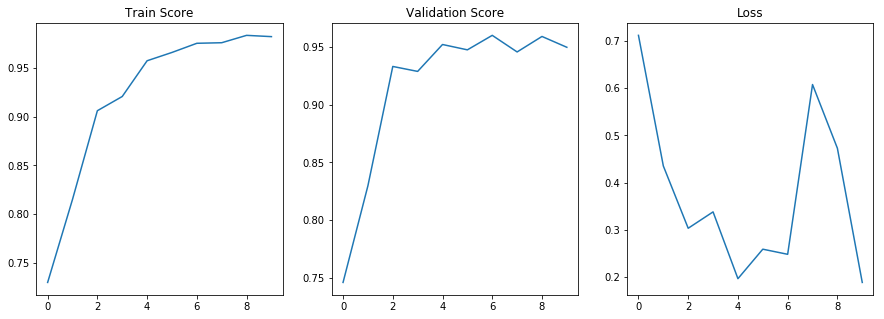

100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


[[0.6913497207180318, 0.6816046987592205, 0.7013079350189743, 0.6925899671683793, 0.7194548671811709, 0.7220227689421397, 0.7363716795292713, 0.8288172088858569, 0.7968905896900182, 0.9185082931821089], [0.7111057091262676, 0.6714995138213642, 0.7146305042366996, 0.7077892762883733, 0.7454333935268788, 0.7277746909292957, 0.7547055146548132, 0.8396999583275456, 0.8062404500625087, 0.9402521183497707], [0.6126507520675659, 0.7085253000259399, 0.6712981462478638, 0.7077914476394653, 0.5879105925559998, 0.6252861618995667, 0.7603048086166382, 0.4806554615497589, 0.466251015663147, 0.24160413444042206]]


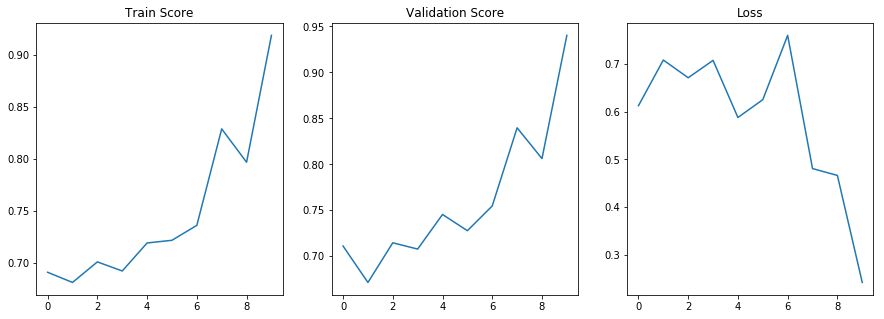

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np

stacked_layers = [3, 3, 3, 3, 3, 3]
filters_per_layers = [16, 32, 64, 64, 128, 128]
linear_dim = [128, 2]

for i in range(10):
    model = CNNModel(1, stacked_layers, filters_per_layers, linear_dim)
    
    weights = [1., 6.]
    optimizer = Adam(model.parameters(), lr=np.random.uniform(1e-4, 5e-3))

    losses, score, train_score = trainer.train(model, optimizer, train_loader, test_loader)    
    scores = [train_score, score, losses]
    
    f, axes = plt.subplots(1, 3, figsize=(15,5))
    titles = ["Train Score", "Validation Score", "Loss"]
    print(scores)
    for i, title in enumerate(titles):
        axes[i].plot(scores[i])
        axes[i].set_title(title)
    plt.show()
    
#         axes[i].show()


In [43]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [44]:
X_test = TensorDataset(Tensor(rd.test_set))
test_dl = DataLoader(X_test, batch_size = 64, shuffle=False)

NO_MODELS_TO_ENSAMBLE = 5
ensamble = Ensamble("./models", NO_MODELS_TO_ENSAMBLE)
predictions = ensamble.make_predictions(test_dl)

save_predictions(predictions)

['./models/cdf3d328cad836361411758439e01e69.pth', './models/1820a5d0dbbf1962986b0664747c9ad1.pth', './models/c291f011ed12445d0b4cb63237a63986.pth', './models/8f24a6842e2a62d76743ba12dc9f8953.pth', './models/51f7c05e46d23e5324cbab950dac00e3.pth']
